In [1]:
%env CUDA_VISIBLE_DEVICES=-1
from typing import Callable, Dict, List, Optional

import math
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import torch
from chirho.counterfactual.handlers.counterfactual import \
    MultiWorldCounterfactual
from chirho.explainable.handlers import ExtractSupports, SearchForExplanation
from chirho.indexed.ops import IndexSet, gather
from chirho.observational.handlers import condition

pyro.settings.set(module_local_params=True)

env: CUDA_VISIBLE_DEVICES=-1


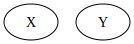

In [2]:
def model():
    X = pyro.sample("X", dist.Bernoulli(0.5))
    Y = pyro.sample("Y", dist.Bernoulli(0.5))

    return {"X": X, "Y": Y}

with ExtractSupports() as extract_supports:
    model()
    supports = {k: constraints.boolean for k in extract_supports.supports}

pyro.render_model(model)


In [3]:
with MultiWorldCounterfactual() as mwc:  
        with SearchForExplanation(
            supports=supports,
            antecedents={"X": torch.tensor(1.0)},
            consequents={"Y": torch.tensor(1.0)},
            witnesses={},
            alternatives={"X": torch.tensor(0.0)},
            antecedent_bias=-0.5,
            consequent_scale=0,
        ):
            with pyro.plate("sample", size=3):
                with pyro.poutine.trace() as trace:
                    model()

In [4]:
for name, node in trace.trace.nodes.items():
    print(name)
    print(node["value"])

trace.trace.nodes["__cause____consequent_Y"]["fn"].log_factor
#The above should not have been all zeros

__cause____antecedent_X
tensor([0, 0, 0])
X
tensor([[[[[1., 0., 1.]]]],



        [[[[0., 0., 0.]]]],



        [[[[1., 1., 1.]]]]])
__cause____consequent_Y
tensor([], size=(3, 1, 1, 1, 3, 0))
Y
tensor([0., 1., 1.])


tensor([[[[[0., 0., 0.]]]],



        [[[[0., 0., 0.]]]],



        [[[[0., 0., 0.]]]]])